In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite",echo=True)

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)


2024-01-22 21:12:04,001 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2024-01-22 21:12:04,011 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-01-22 21:12:04,019 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("measurement")
2024-01-22 21:12:04,035 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-01-22 21:12:04,086 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2024-01-22 21:12:04,090 INFO sqlalchemy.engine.Engine [raw sql] ('measurement',)
2024-01-22 21:12:04,095 INFO sqlalchemy.engine.Engine PRAGMA main.foreign_key_list("measurement")
2024-01-22 21:12:04,097 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-01-22 21:12:04,101 INFO sqlalchemy.engine.Engine PRAGMA temp.foreign_key_list("measurement")
2024-01-22 21:12:04,109 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-01-22 21:12:04,113 INFO sqlalchemy.engine.Engine SELECT sql

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement= Base.classes.measurement
station= Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
print(recent_date)


2024-01-22 21:12:04,382 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-01-22 21:12:04,399 INFO sqlalchemy.engine.Engine SELECT measurement.date AS measurement_date 
FROM measurement ORDER BY measurement.date DESC
 LIMIT ? OFFSET ?
2024-01-22 21:12:04,401 INFO sqlalchemy.engine.Engine [generated in 0.00284s] (1, 0)
2017-08-23


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
perc_data = session.query(measurement.date, measurement.prcp)\
            .filter(measurement.date >= year_ago)\
            .order_by(measurement.date).all()

# # Save the query results as a Pandas DataFrame. Explicitly set the column names
p_df = pd.DataFrame(perc_data, columns=['Date', 'Precipitation'])


# # Sort the dataframe by date
p_df.sort_values(by='Date', inplace=True)


2024-01-22 21:12:04,485 INFO sqlalchemy.engine.Engine SELECT measurement.date AS measurement_date, measurement.prcp AS measurement_prcp 
FROM measurement 
WHERE measurement.date >= ? ORDER BY measurement.date
2024-01-22 21:12:04,491 INFO sqlalchemy.engine.Engine [generated in 0.00603s] ('2016-08-23',)


In [11]:
p_df

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
...,...,...
2225,2017-08-22,0.50
2228,2017-08-23,0.08
2226,2017-08-23,0.00
2227,2017-08-23,0.00


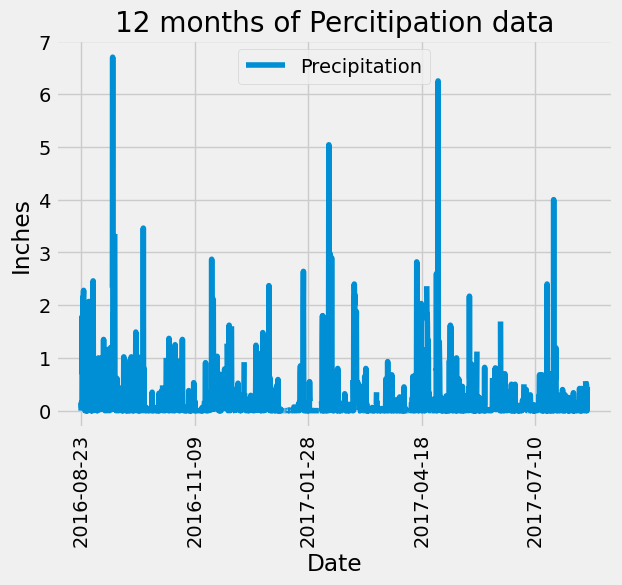

In [12]:

# Use Pandas Plotting with Matplotlib to plot the data
p_df.plot(x='Date', y='Precipitation', rot=90)


plt.title('12 months of Percitipation data')
plt.xlabel("Date")
plt.ylabel("Inches")

plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
p_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
station_data = session.query(func.count(station.station)).first()[0]
print(station_data)

2024-01-22 21:12:05,327 INFO sqlalchemy.engine.Engine SELECT count(station.station) AS count_1 
FROM station
 LIMIT ? OFFSET ?
2024-01-22 21:12:05,334 INFO sqlalchemy.engine.Engine [generated in 0.00701s] (1, 0)
9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
active_stations

2024-01-22 21:12:05,409 INFO sqlalchemy.engine.Engine SELECT measurement.station AS measurement_station, count(measurement.station) AS count_1 
FROM measurement GROUP BY measurement.station ORDER BY count(measurement.station) DESC
2024-01-22 21:12:05,413 INFO sqlalchemy.engine.Engine [generated in 0.00406s] ()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_id = session.query(func.min(measurement.tobs),
                                  func.max(measurement.tobs),
                                  func.avg(measurement.tobs))\
    .filter(measurement.station == 'USC00519281')\
.all()
station_id

2024-01-22 21:12:05,514 INFO sqlalchemy.engine.Engine SELECT min(measurement.tobs) AS min_1, max(measurement.tobs) AS max_1, avg(measurement.tobs) AS avg_1 
FROM measurement 
WHERE measurement.station = ?
2024-01-22 21:12:05,520 INFO sqlalchemy.engine.Engine [generated in 0.00752s] ('USC00519281',)


[(54.0, 85.0, 71.66378066378067)]

2024-01-22 21:12:05,594 INFO sqlalchemy.engine.Engine SELECT measurement.tobs AS measurement_tobs, measurement.station AS measurement_station 
FROM measurement 
WHERE measurement.station = ? AND measurement.date >= ?
2024-01-22 21:12:05,597 INFO sqlalchemy.engine.Engine [generated in 0.00266s] ('USC00519281', '2016-08-23')


<Figure size 500x200 with 0 Axes>

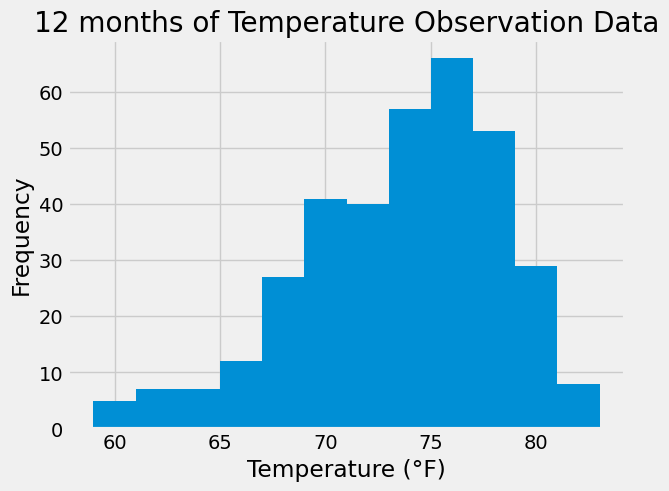

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_id = session.query(measurement.tobs, measurement.station)\
            .filter(measurement.station == "USC00519281")\
            .filter(measurement.date >= year_ago)\
            .all()

active_df = pd.DataFrame(active_id, columns=['Temperature','Frequency'])

plt.figure(figsize=(5,2))
active_df.hist(bins=12)
plt.title("12 months of Temperature Observation Data" )
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")


plt.show()


# Close Session

In [18]:
# Close Session
session.close()

2024-01-22 21:12:06,067 INFO sqlalchemy.engine.Engine ROLLBACK
